# Dogs vs. Cats 
**Kaggle challenge**: https://www.kaggle.com/c/dogs-vs-cats

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import random
from matplotlib import pyplot as plt

## Exploring the dataset

In [3]:
PATH = 'dogscats'
os.listdir(PATH)

['train', 'valid', 'test1', 'sample', 'models']

In [116]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'valid')
test_dir = os.path.join(PATH, 'test1')

# How many cats and dogs in the dataset
train_dogs = os.path.join(train_dir, 'dogs')
train_cats = os.path.join(train_dir, 'cats')

print('Train. Dogs = %d' % len(os.listdir(train_dogs)))
print('Train. Cats = %d' % len(os.listdir(train_cats)))

# Valid images
val_dogs = os.path.join(val_dir, 'dogs')
val_cats = os.path.join(val_dir, 'cats')
print('Validation. Dogs = %d' % len(os.listdir(val_dogs)))
print('Validation. Cats = %d' % len(os.listdir(val_cats)))

# Test images
print('Test images = %d' % len(os.listdir(test_dir)))

Train. Dogs = 11500
Train. Cats = 11500
Validation. Dogs = 1000
Validation. Cats = 1000
Test images = 12500


**How are the images in the dataset?**

Images are RGB (3 channels), but with different sizes

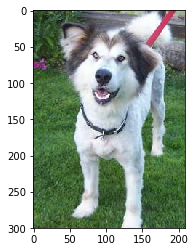

In [5]:
dog_file = os.listdir(train_dogs)[12]
img = plt.imread(os.path.join(train_dogs, dog_file))
plt.imshow(img)

In [6]:
img.shape

(300, 209, 3)

# Set up initial model with Keras

In [108]:
from keras.models import Sequential, Model
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import cv2

### Data Preprocessing

**Create datasets from files**

In [185]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

# Training data
train_dogs_images = [os.path.join(train_dogs, i) for i in os.listdir(train_dogs)]
train_cats_images = [os.path.join(train_cats, i) for i in os.listdir(train_cats)]

# Shuffle cats and dogs
train_images = train_dogs_images + train_cats_images
random.shuffle(train_images)

# Validation data
val_dogs_images = [os.path.join(val_dogs, i) for i in os.listdir(val_dogs)]
val_cats_images = [os.path.join(val_cats, i) for i in os.listdir(val_cats)]
val_images = val_dogs_images + val_cats_images
random.shuffle(val_images)

# Test data
test_images = [os.path.join(test_dir, i) for i in os.listdir(test_dir)]

In [183]:
def read_image(img_path):
    """Read an image from its path, and resize it
        - img_path: Path to the image
    """
    img = (cv2.imread(img_path))[...,::-1] # openCV load images as BGR -> reverse to RGB
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    return img

def prepare_data(img_list):
    """Create an numpy array with data corresponding to images in img_list
        - img_list: List of path to image files
    """
    # Prepare the array for the data (dimensions)
    data = np.ndarray((len(img_list), IMG_HEIGHT, IMG_WIDTH, CHANNELS))

    for i, image_file in enumerate(img_list):
        data[i] = read_image(image_file)
        if i%1000 == 0: 
            print('Processed %d images of %d' % (i, len(img_list)))
    
    print('Shape of data %s' % (data.shape,))
    return data

In [186]:
train = prepare_data(train_images)
val = prepare_data(val_images)

Processed 0 images of 23000
Processed 1000 images of 23000
Processed 2000 images of 23000
Processed 3000 images of 23000
Processed 4000 images of 23000
Processed 5000 images of 23000
Processed 6000 images of 23000
Processed 7000 images of 23000
Processed 8000 images of 23000
Processed 9000 images of 23000
Processed 10000 images of 23000
Processed 11000 images of 23000
Processed 12000 images of 23000
Processed 13000 images of 23000
Processed 14000 images of 23000
Processed 15000 images of 23000
Processed 16000 images of 23000
Processed 17000 images of 23000
Processed 18000 images of 23000
Processed 19000 images of 23000
Processed 20000 images of 23000
Processed 21000 images of 23000
Processed 22000 images of 23000
Shape of data (23000, 224, 224, 3)
Processed 0 images of 2000
Processed 1000 images of 2000
Shape of data (2000, 224, 224, 3)


**Generation of labels for train and val dataset**

In [202]:
train_labels = []
for file in train_images:
    if 'dog.' in file:
        train_labels.append(1)
    else:
        train_labels.append(0)

print('[Train] Labelled as dogs: %d' % train_labels.count(1))
print('[Train] Labelled as cats: %d' % train_labels.count(0))

val_labels = []
for file in val_images:
    if 'dog.' in file:
        val_labels.append(1)
    else:
        val_labels.append(0)

print('[Val] Labelled as dogs: %d' % val_labels.count(1))
print('[Val] Labelled as cats: %d' % val_labels.count(0))

[Train] Labelled as dogs: 11500
[Train] Labelled as cats: 11500
[Val] Labelled as dogs: 1000
[Val] Labelled as cats: 1000


# Transfer learning

**Base model: VGG19**

We will use a network already trained (with imagenet) and will add some layers at the end that we will train with our dataset

In [207]:
model = VGG19(weights = "imagenet", include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3))

# Freeze the layers that we don't want to retrain (Last 5)
for layer in model.layers:
    layer.trainable = False
    
# Add custom layers to fit the purpose of our task
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create final model
model_final = Model(input = model.input, output = predictions)
model_final.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [208]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [209]:
batch_size = 8
epochs = 2

training_log = model_final.fit(train, train_labels, 
         batch_size = batch_size,
         epochs=epochs,
         validation_split=0.25,
         shuffle=True)

model_final.save_weights('transferred_model.h5')

Train on 17250 samples, validate on 5750 samples
Epoch 1/2
17250/17250 [==============================] - 143s 8ms/step - loss: 0.0525 - acc: 0.9913 - val_loss: 0.0554 - val_acc: 0.9915
Epoch 2/2
17250/17250 [==============================] - 145s 8ms/step - loss: 0.0589 - acc: 0.9916 - val_loss: 0.0759 - val_acc: 0.9903


### Load the model if we have one already

In [ ]:
# Read model already trained
#model_final.load_weights('vgg19.h5')
#model_final.load_weights('vgg19-softmax.h5')
model_final.load_weights('transferred_model.h5')

# Training log

In [ ]:
training_log.history

dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


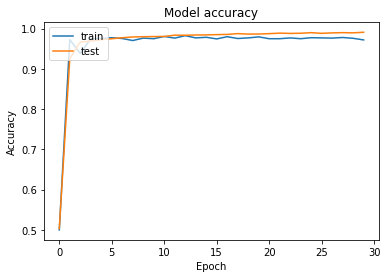

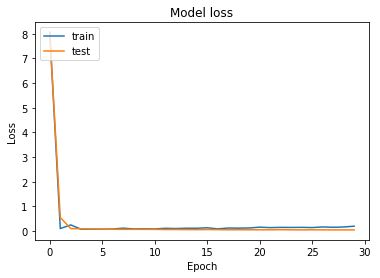

In [13]:
print(training_log.history.keys())

# Model accuracy
plt.plot(training_log.history['val_acc'])
plt.plot(training_log.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Model loss
plt.plot(training_log.history['val_loss'])
plt.plot(training_log.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Exploration of the results

Let's have a look to:
* A few correct labels at random
* A few incorrect labels at random
* The most correct labels of each class (ie those with highest probability that are correct)
* The most incorrect labels of each class (ie those with highest probability that are incorrect)
* The most uncertain labels (ie those with probability closest to 0.5).


In [211]:
# Original labels of validation set in val_labels
# Prediction for the validation set (already in 0 and 1)
val_predictions = model_final.predict(val) 

In [215]:
val_predictions = np.squeeze(val_predictions)
val_predictions

array([6.0914113e-25, 1.6924248e-28, 0.0000000e+00, ..., 1.0000000e+00,
       9.4554953e-10, 0.0000000e+00], dtype=float32)

In [230]:
def predicted_classes(probs, threshold):
    return np.array(['1' if pred > threshold else '0' for pred in probs]).astype(np.int)

In [231]:
# Accuracy of the model on the validation set
val_classes = predicted_classes(val_predictions, 0.5)
unique, counts = np.unique(val_classes == val_labels, return_counts=True)
print(dict(zip(unique,counts)))
print('Accuracy = %.2f' % (counts[1]/len(val_labels)).astype(np.float64))

{False: 45, True: 1955}
Accuracy = 0.98


In [218]:
def rand_by_mask(mask):
    """Returns a list of random indexes to images that are classified correctly or incorrectly (depending on the mask)"""
    return np.random.choice(np.where(mask)[0], 5, replace=False)

def rand_by_correct(is_correct):
    """Returns a list of random indexes to images that are classified correctly or incorrectly (depending on is correct)"""
    mask = (val_classes == val_labels) == is_correct
    return rand_by_mask(mask)

In [243]:
def plot_val_images_with_title(idxs, filenames_list, title):   
    imgs_files = [filenames_list[x] for x in idxs]
    imgs = [plt.imread(i) for i in imgs_files]
    
    print(title)
    f = plt.figure(figsize=(14,8))
    rows = 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        title = 'cat: ' + str(1-val_predictions[idxs[i]]) if val_classes[idxs[i]]==0 else 'dog: ' + str(val_predictions[idxs[i]])
        sp.set_title(title)
        plt.imshow(imgs[i])

Correctly classified (random)


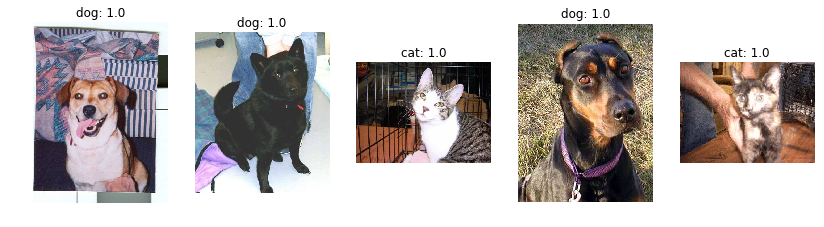

In [247]:
plot_val_images_with_title(rand_by_correct(True), val_images, 'Correctly classified (random)')

Incorrectly classified (random)


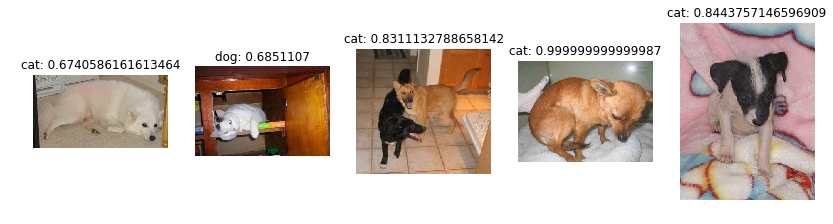

In [255]:
plot_val_images_with_title(rand_by_correct(False), val_images, 'Incorrectly classified (random)')

In [222]:
def most_by_mask(mask, mult):
    """Returns a list of indexes of the best predictions by class"""
    idxs = np.where(mask)[0]
    idxs_sorted = np.argsort(mult * val_predictions[idxs])
    #return val_predictions[idxs][idxs_sorted]
    return idxs[idxs_sorted][:5]
    
def most_by_correct(class_tag, is_correct):
    """Returns a list of indexes of the best/worst predictions (depending on is_correct) by class"""
    mask = (val_classes == val_labels) == is_correct
    return most_by_mask(mask, -1) if class_tag == 1 else most_by_mask(mask, 1)
    #return most_by_mask(mask, -1)

Most correct dogs


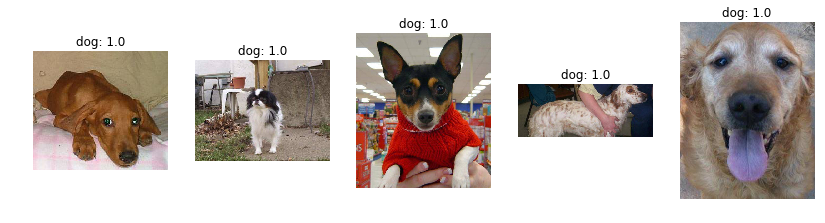

In [323]:
plot_val_images_with_title(most_by_correct(1, True), val_images, 'Most correct dogs')

Most correct cats


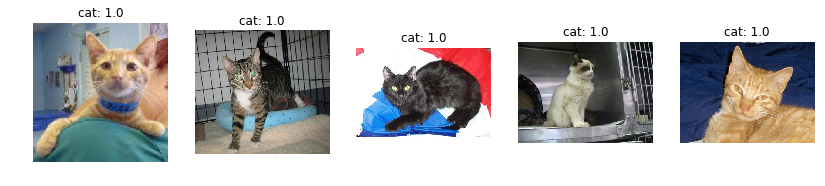

In [250]:
plot_val_images_with_title(most_by_correct(0, True), val_images, 'Most correct cats')

Most incorrect dogs


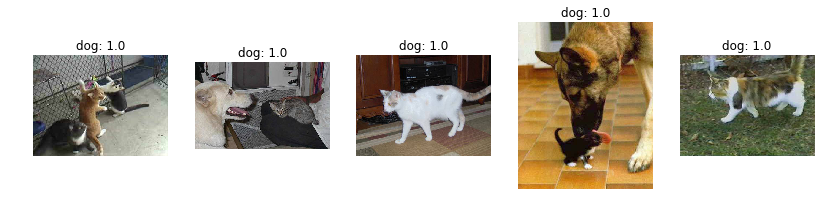

In [251]:
plot_val_images_with_title(most_by_correct(1, False), val_images, 'Most incorrect dogs');

Most incorrect cats


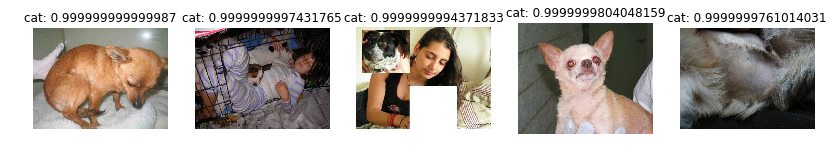

In [252]:
plot_val_images_with_title(most_by_correct(0, False), val_images, 'Most incorrect cats')

Most uncertain predictions


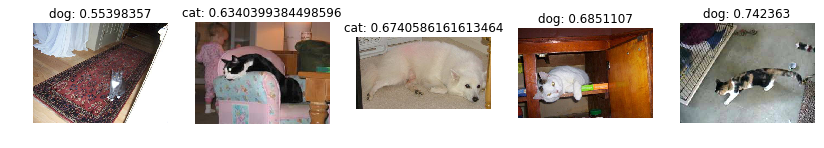

In [253]:
most_uncertain = np.argsort(np.abs(val_predictions -0.5))[:5]
plot_val_images_with_title(most_uncertain, val_images, 'Most uncertain predictions')

# Predicted values for test data (submission results)

In [256]:
print('Test images = %d' % len(os.listdir(test_dir)))b

Test images = 12500


In [283]:
# Sort test data by natural order
test_images.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

# Prepare data for testing
test = prepare_data(test_images)

Processed 0 images of 12500
Processed 1000 images of 12500
Processed 2000 images of 12500
Processed 3000 images of 12500
Processed 4000 images of 12500
Processed 5000 images of 12500
Processed 6000 images of 12500
Processed 7000 images of 12500
Processed 8000 images of 12500
Processed 9000 images of 12500
Processed 10000 images of 12500
Processed 11000 images of 12500
Processed 12000 images of 12500
Shape of data (12500, 224, 224, 3)


In [284]:
test_predictions = model_final.predict(test)

In [286]:
test_classes = predicted_classes(test_predictions, 0.5)

** Check some random images to see how it went**

In [366]:
def plot_test_images_with_title(idxs, filenames_list, title):   
    imgs_files = [filenames_list[x] for x in idxs]
    imgs = [plt.imread(i) for i in imgs_files]
    
    print(title)
    f = plt.figure(figsize=(14,8))
    rows = 1
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs)//rows, i+1)
        sp.axis('Off')
        title = 'cat: ' + str(test_predictions[idxs[i]]) if test_classes[idxs[i]]==0 else 'dog: ' + str(test_predictions[idxs[i]])
        sp.set_title(title)
        plt.imshow(imgs[i])

Random test images and predicted class


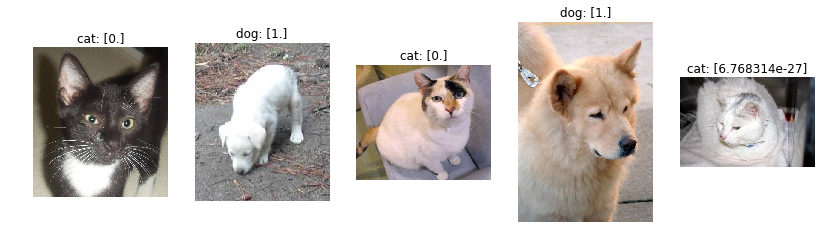

In [368]:
random_idx = np.random.choice(list(range(0,len(test))), 5, replace=False)
plot_test_images_with_title(random_idx, test_images, 'Random test images and predicted class')

Most uncertain predictions


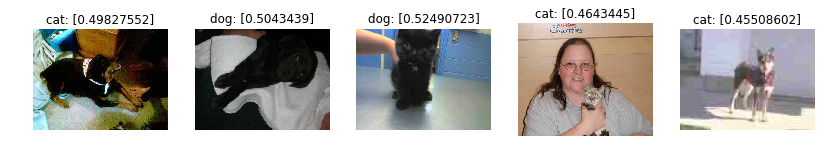

In [375]:
most_uncertain = np.argsort(np.abs(np.squeeze(test_predictions) -0.5))[:5]
plot_test_images_with_title(most_uncertain, test_images, 'Most uncertain predictions')

**Prepare the csv for the submission**

In [313]:
def create_submission(filename, test_classes):
    with open(filename, 'w') as f:
        # Write header
        f.write('id,label\n')
        
        # Zip the predicted classes for each image to its index
        idx = [i for i in range(1,len(test_classes)+1)]
        test_submission = list(zip(idx, test_classes))
        
        np.savetxt(f, test_submission, delimiter=",", fmt="%d")

In [315]:
create_submission('submission.csv', test_classes)